Script that creates labeled data with Madagascar and then trains a classification network

In [1]:
%%file SConstruct

from rsf.proj import *

# identifier for this experiment
experiment_name = 'frequency-labeling'
# unique labelers for ml experiments
ml_label = 'ml_label' # this will hold the unique "bin in our frequency list"
ml_nclasses = 'ml_nclasses' # this says how many classes we worry about
ml_type  = 'ml_type'  # this says what frequency it is

# generate a series of sythetic seismic traces using sigmoid


# how many samples will we want our learning inputs to be?
lrnspl = 128
# and how many learning samples per trace?
nspl = 4
# sigmoid model parameters
n1 = lrnspl*nspl
d1 = 0.004
o1 = 0
n2 = 51
d2 = 0.1
o2 = 0

# name for traces
traces = experiment_name+'-traces'
Flow(traces,None,
   '''
   sigmoid 
   o1=%g d1=%g n1=%i 
   o2=%g d2=%g n2=%i 
   taper=n'''%(o1,d1,n1,o2,d2,n2))


# list of frequencies for modeling, these are our classes for machine learning
freqlist = [15,30,45,60]
# noise parameters
# noise mean
meanlst = [0]
# noise range
rangelst = [0,.1,.25]
# noise variance
varlst = [0,.1,.25]
# noise type (normal/uniform)
typelst = ['y']

# list of all files generated here
filelst = []

# loop throgh frequencies and convolve
for f in range(len(freqlist)):
    # what's the frequency, kenneth?
    freq = freqlist[f]
    # perform the convolution, scale so maximum value is 1
    convolved = traces+'-convolved-%i'%f
    Flow(convolved,traces,'ricker1 frequency=%g | scale axis=2'%freq)
    # loop through noise parameters and add to the convolved traces
    for m in range(len(meanlst)):
        # get noise mean
        noisemean = meanlst[m]
        mean = convolved+'-%i'%m
        for r in range(len(rangelst)):
            # get noise range
            noiserange = rangelst[r]
            rang = mean+'-%i'%r
            for v in range(len(varlst)):
                # get noise variance
                noisevar = varlst[v]
                var = rang+'-%i'%v
                for t in range(len(typelst)):
                    noisetype = typelst[t]
                    Flow(var,convolved,
                       '''
                       noise mean=%g range=%g 
                       var=%g type=%s
                       '''%(noisemean,noiserange,noisevar,noisetype))
                    # output the noised traces with frequency labels
                    for i2 in range(n2):
                        # identifier for this trace
                        trac = var+'-%i'%i2
                        # what part of the trace
                        for i1 in range(nspl):
                            part = trac+'-%i'%i1
                            # window out trace, put identifier
                            # the put command will place the ml classification info
                            # in the .rsf file's header info to make it easier to 
                            # use later during tensorflow operations
                            Flow(part,var,
                               '''
                               window n2=1 f2=%i n1=%i f1=%i| 
                               put %s=%g %s=%g %s=%i
                               '''%(i2,lrnspl,lrnspl*i1,
                                    ml_label,f,
                                    ml_type,freq,
                                    ml_nclasses,len(freqlist)))
                            # add this file to the filelst
                            filelst.append(part+'.rsf')
                            
# write out the list of all files
with open(experiment_name+'-files.txt','w') as filehandle:
    for example in filelst:
        filehandle.write('%s\n'%example)               
            
# write out the list of frequencies corresponding to each bin
with open(experiment_name+'-labels.txt','w') as filehandle:
    for f in range(len(freqlist)):
        filehandle.write('label=%i\ttype=%g\n'%(f,freqlist[f]))

End()

Overwriting SConstruct


In [2]:
# run the sconstruct file
import os
os.system('pscons')

0

In [1]:
# relevant imports
import numpy as np
import tensorflow as tf
import m8r
import os
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
# test if gpu working
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
# seed for assigning testing and training
rnd.seed(1)

Default GPU Device:/device:GPU:0


In [2]:
def read_and_label(filedir,ml_labelstring="ml_label",
                   ml_nclassesstring="ml_nclasses", ml_classnamestring="ml_type"):
    # function for reading a rsf file, 
    # determinging its machine learning label, 
    # and outputting its sampling
    inp = m8r.Input(filedir)
    # file sampling
    n1 = inp.int("n1") # this is equal to 128 in our example
    n2 = inp.int("n2") # this is equal to 1 in our example
    N = [n2,n1] # adding an extra dummy dimension
    # read data
    data = inp.read(shape=N)
    # classification for ml problem
    ml_type     = inp.int(ml_labelstring) # class of each
    ml_nclasses = inp.int(ml_nclassesstring) # total number of classes
    ml_classname= inp.float(ml_classnamestring) # class name for this class
    return data, ml_type, ml_nclasses, N, ml_classname

In [3]:
# experiment name
experiment_name = 'frequency-labeling'
# current working directory
cwd = os.getcwd()
# directory with the examples
exdir = cwd
# exdir = cwd+'/sinewave'
# name of file with the list of examples
exfile = experiment_name+'-files.txt'

In [4]:
# open the list of example files, convert to a list
filelst = []
with open (exdir+'/'+exfile,'r') as filehandle:
    filelst = [current_place.rstrip() for current_place in filehandle.readlines()]

In [5]:

# shuffle the file list so we don't clump our classes together 
rnd.shuffle(filelst)

# portion of data for testing ?
testfrac = 0.1

# flags for if our trainining and testing datasets have begun
beguntest = False
beguntrain = False

# initialize the labels array by reading the first element
temp_data, temp_ml_type, temp_nclasses, temp_N, temp_ml_classname = read_and_label(exdir+'/%s'%filelst[0])
# create float array for holding frequency labels
labels_array = np.zeros(temp_nclasses,dtype=float)
# boolean array for saying if the labels have been read
need_labels  = np.ones(temp_nclasses,dtype=bool)
# loop through file list, read data and labels
for example in filelst:    
    temp_data, temp_ml_type, temp_nclasses, temp_N, temp_ml_classname = read_and_label(exdir+'/%s'%example)
    # have we gotten the label from this ml type?
    if need_labels[temp_ml_type]:
        labels_array[temp_ml_type] = temp_ml_classname
        need_labels[temp_ml_type] = False
    # transform the ml type into a 1x1 array for concactonation
    temp_ml_type = np.array([[temp_ml_type]])
    # call random number, are we abbove or below?
    if rnd.random() < testfrac:
        # have we initialized the numpy arrays?
        if beguntest:
            dataarray_test = np.concatenate((dataarray_test,temp_data),axis=0)
            labelarray_test = np.concatenate((labelarray_test,temp_ml_type),axis=0)
        else:
            dataarray_test = temp_data
            labelarray_test = temp_ml_type
            beguntest = True
    else:
        # have we initialized the numpy arrays?
        if beguntrain:
            dataarray_train  = np.concatenate((dataarray_train,temp_data),axis=0)
            labelarray_train = np.concatenate((labelarray_train,temp_ml_type),axis=0)
        else:
            dataarray_train = temp_data
            labelarray_train = temp_ml_type
            beguntrain = True



In [6]:
# reshape arrays for tf compatibility, adding dummy 3rd dimension and 2nd dimension 
dataarray_train = np.reshape(dataarray_train,[dataarray_train.shape[0],temp_N[0],temp_N[1]])
dataarray_test = np.reshape(dataarray_test,[dataarray_test.shape[0],temp_N[0],temp_N[1]])

In [7]:
# turn our lists into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dataarray_train, labelarray_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((dataarray_test , labelarray_test ))

In [8]:
# shuffle and batch the datasets
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE=100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset  = test_dataset.batch(BATCH_SIZE)

In [9]:
# build and train a model
model = tf.keras.Sequential([
            tf.keras.layers.Reshape((temp_N[1],1), input_shape=(1,temp_N[1],)),
            tf.keras.layers.Conv1D( filters=64, kernel_size=5, activation='relu',input_shape=(temp_N[1],1)),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D( filters=64, kernel_size=5, activation='relu',input_shape=(temp_N[1],1)),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Dense(16,activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(temp_nclasses,activation='softmax') # output is the dimension of the number of frequency classes
        ])
# compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 58, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
dense (Dense)                (None, 29, 16)            1040      
_________________________________________________________________
flatten (Flatten)            (None, 464)               0

In [10]:
# fit the model
model.fit(train_dataset, epochs=10)

Train for 104 steps
Epoch 1/10
104/104 [==============================] - 2s 21ms/step - loss: 1.2629 - sparse_categorical_accuracy: 0.4736
Epoch 2/10
104/104 [==============================] - 1s 7ms/step - loss: 1.0493 - sparse_categorical_accuracy: 0.7540
Epoch 3/10
104/104 [==============================] - 1s 7ms/step - loss: 0.9794 - sparse_categorical_accuracy: 0.7979
Epoch 4/10
104/104 [==============================] - 1s 7ms/step - loss: 0.9491 - sparse_categorical_accuracy: 0.8129
Epoch 5/10
104/104 [==============================] - 1s 7ms/step - loss: 0.9325 - sparse_categorical_accuracy: 0.8196
Epoch 6/10
104/104 [==============================] - 1s 7ms/step - loss: 0.9222 - sparse_categorical_accuracy: 0.8279
Epoch 7/10
104/104 [==============================] - 1s 7ms/step - loss: 0.9137 - sparse_categorical_accuracy: 0.8363
Epoch 8/10
104/104 [==============================] - 1s 7ms/step - loss: 0.9046 - sparse_categorical_accuracy: 0.8469
Epoch 9/10
104/104 [=======

In [11]:
# evaluate the accuracy on the testing dataset 

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

print('\nTest accuracy:', test_acc)

12/12 - 0s - loss: 0.9149 - sparse_categorical_accuracy: 0.8308

Test accuracy: 0.83081156


In [12]:
# make predictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# apply to the test dataset
predictions = probability_model.predict(dataarray_test)

In [13]:
# function for plotting results
def plotelement(i,dataset,classnames,class_probabilities,true_label):  
    # show the trace
    plt.plot(dataset[i,0,:])
    plt.ylabel('Predicted Class is %g Hz'%classnames[np.argmax(class_probabilities[i])])
    plt.xlabel('True Class is %g Hz'%classnames[true_label[i]])
    plt.show()
    # show the probability models
    plt.bar(range(len(classnames)), class_probabilities[i], color="#777777")
    plt.title('Frequency Probabilities')
    plt.xticks(np.arange(len(classnames)),classnames)
    plt.ylabel('Probability')
    plt.xlabel('Frequency (Hz)')
    plt.show()
    return

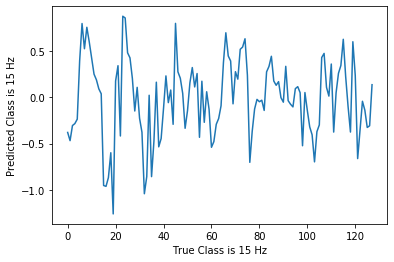

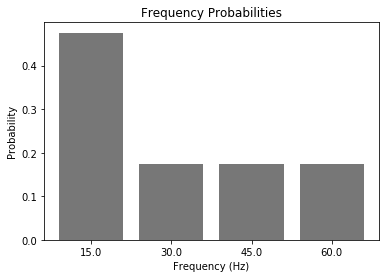

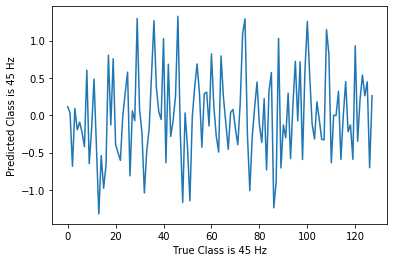

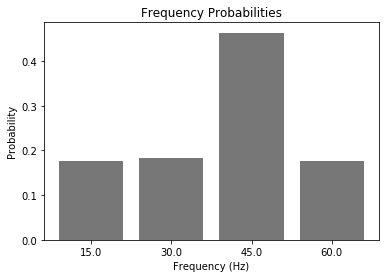

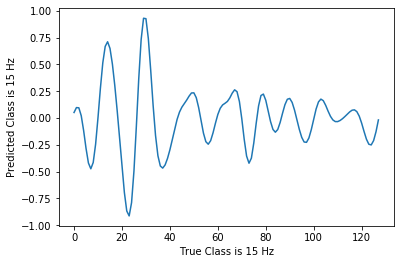

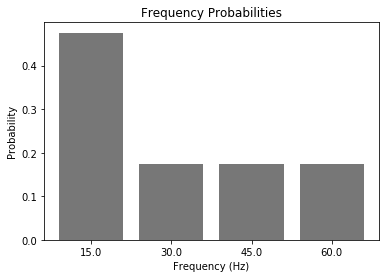

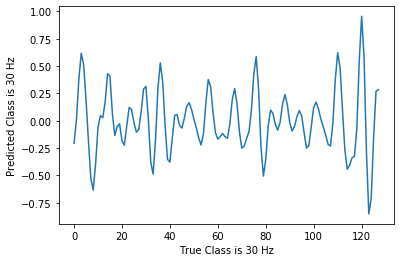

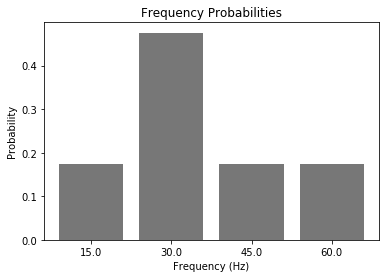

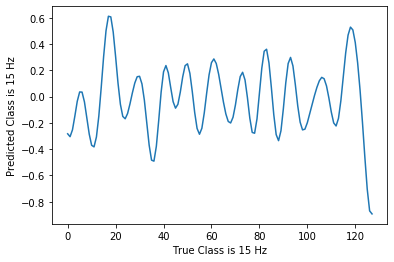

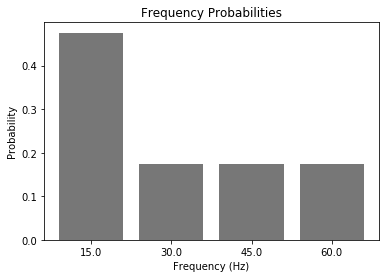

In [14]:
# list of elements to plot
elelst=[1,3,19,25,12]
for e in elelst:
    plotelement(e,dataarray_test,labels_array,predictions,labelarray_test)